# Curve Fitting With Python

<br>

**Table of Contents**:

- [Introduction](#Introduction)
- [Creating The Data](#Creating-The-Data)
- [Curve Fitting](#Curve-Fitting)
- [Plotting The Results](#Plotting-The-Results)
    - [Fitted Curve](#Fitted-Curve) <br>
    - [Residual Plot](#Residual-Plot) <br>
    - [Final Plot](#Final-Plot)

<br>

## Introduction

We start our notebook by:

- Importing all necessary libraries,
- Setting some default parameters (mainly for plotting), and
- Defining two useful functions.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

import lmfit
from lmfit import Model
import scipy.stats as stats

In [2]:
pd.set_option('display.precision', 3)

%config InlineBackend.figure_format = 'retina'

label_size = 20
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size

plt.rcParams['lines.linewidth'] = 3

plt.rcParams['legend.fontsize'] = label_size - 2
plt.rcParams['legend.frameon'] = False

# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

Curve fitting requires that we define the function that maps examples of inputs to outputs. We know from the task description that both peaks have a [Lorentzian lineshape](https://en.wikipedia.org/wiki/Cauchy_distribution).

Therefore, we define the `Lorentzian()` function that, for a given x-range (`x`), returns a Lorentzian peak with a given amplitude (`amp`), centre (`cen`), and HWHM (`gamma`). The second function (`Douple_Lorentzian()`) uses the first one to return two peaks, each with its own characteristics.

In [3]:
def Lorentzian(x, amp, cen, gamma):
    return amp * gamma / (np.pi * ((x - cen)**2 + gamma**2))


def Douple_Lorentzian(x, amp1, cen1, gamma1, amp2, cen2, gamma2):
    return Lorentzian(x, amp1, cen1, gamma1) +\
           Lorentzian(x, amp2, cen2, gamma2)

<br>

## Creating The Data

Let's create the spectrum for our imaginary material.

In [4]:
np.random.seed(1)

x = np.linspace(400, 406, 150)

y_clean = Douple_Lorentzian(x, 1.54, 402.2, 0.34, 1.00, 403.7, 0.65)
y = y_clean + 0.075 * np.random.normal(0, np.mean(y_clean), 150)

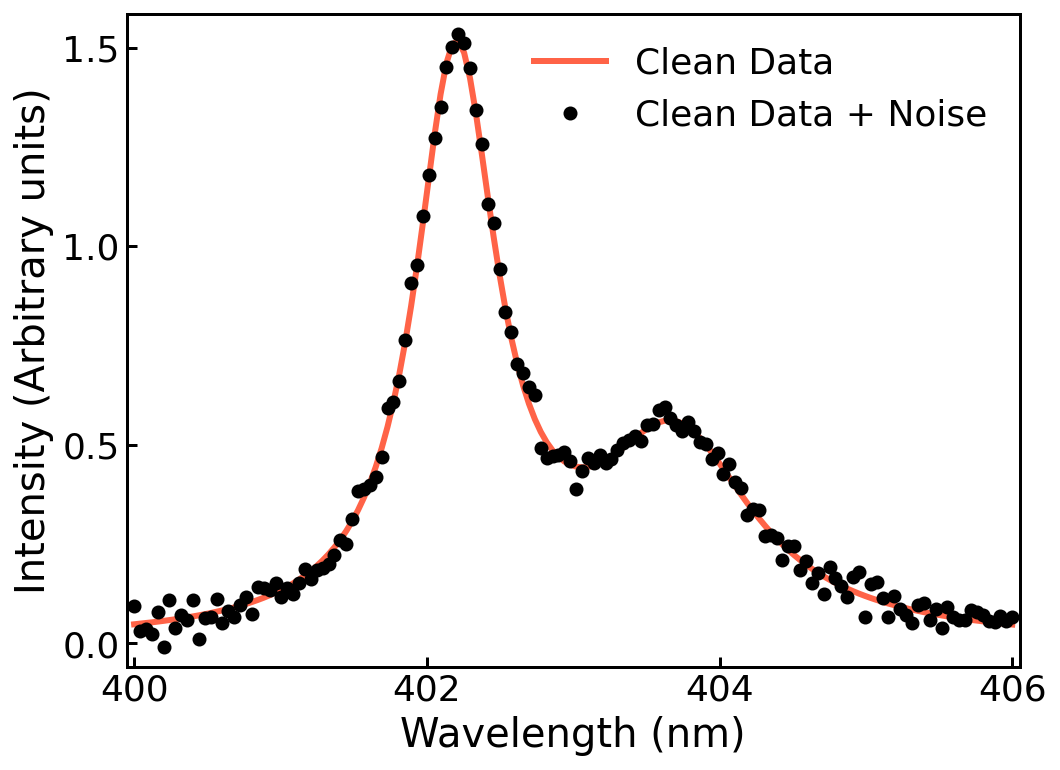

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y_clean, color='tomato', label='Clean Data')
ax.plot(x, y, color='k', marker='o', linestyle='', label='Clean Data + Noise')

ax.set_xlabel('Wavelength (nm)')
ax.set_xlim([399.95, 406.05])
ax.set_xticks([400, 402, 404, 406])

ax.set_ylabel('Intensity (Arbitrary units)')
ax.set_ylim([y.min() - 0.05, y.max() + 0.05])
ax.set_yticks([0, 0.50, 1.00, 1.50])

ax.legend(loc=0);

Notice that the second peak (circa 404 nm) has a smaller amplitude and broader linewidth than the first one. Also, owing to their spectral proximity and characteristics, the two peaks overlap around ~403 nm.

Random noise is added to simulate real experimental conditions.

<br>

## Curve Fitting

We are ready to fit our spectrum. I have organised this process into five steps (for a more detailed description, please see [here](https://lmfit-py.readthedocs.io/_/downloads/en/0.9.4/pdf/)).

In [6]:
# Step 1: Create a model from the user-defined function 'Double_Lorentzian'
model = Model(Douple_Lorentzian)

# Step 2: Set parameter hints (initial value and min-max constraints)
model.set_param_hint('amp1', value=1.50, min=1.2, max=1.75)
model.set_param_hint('cen1', value=402.4, min=402, max=402.6)
model.set_param_hint('gamma1', value=0.30, min=0.2, max=0.5)
model.set_param_hint('amp2', value=0.60, min=0.40, max=1.2)
model.set_param_hint('cen2', value=403.7, min=403.2, max=404)
model.set_param_hint('gamma2', value=0.50, min=0.30, max=0.75)

# Step 3: Generate parameters with the expected values
params = model.make_params()

# Step 4: Fit data to this model with the 'param' object
result = model.fit(data=y, params=params, x=x)

# Step 5: Extract and display the best values for each parameter along with R^{2}
slope, intercept, r_val, p_val, std_err = stats.linregress(y, result.best_fit)

fitting_pars = ['amp1', 'cen1', 'gamma1', 'amp2', 'cen2', 'gamma2']
data_dic = {
    'Parameters': ['R-squared'] + fitting_pars,
    'Value': [r_val**2] + [result.params[par].value for par in fitting_pars],
    'Errors': ['-'] + [result.params[par].stderr for par in fitting_pars]
}

pd.DataFrame(data_dic)

,Parameters,Value,Errors
0,R-squared,0.995,-
1,amp1,1.558,0.016
2,cen1,402.202,0.002
3,gamma1,0.342,0.004
4,amp2,0.993,0.021
5,cen2,403.700,0.011
6,gamma2,0.640,0.017


The results are summarised in a Pandas DataFrame. The coefficient of determination (`R-squared`) has a high value (~ 98%), which indicates that our fit is excellent. However, we have to be careful because a [high R-squared value is not always great](https://statisticsbyjim.com/regression/interpret-r-squared-regression/).

A DataFrame is not the only way of presenting the results. `Lmfit` has the `fit_report()` function, which shows the fit statistics, variables, and correlations.

In [7]:
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 150
    # variables        = 6
    chi-square         = 0.09156088
    reduced chi-square = 6.3584e-04
    Akaike info crit   = -1098.20798
    Bayesian info crit = -1080.14417
[[Variables]]
    amp1:    1.55816533 +/- 0.01601513 (1.03%) (init = 1.5)
    cen1:    402.202367 +/- 0.00242654 (0.00%) (init = 402.4)
    gamma1:  0.34231174 +/- 0.00406553 (1.19%) (init = 0.3)
    amp2:    0.99255135 +/- 0.02140838 (2.16%) (init = 0.6)
    cen2:    403.700475 +/- 0.01052470 (0.00%) (init = 403.7)
    gamma2:  0.64048722 +/- 0.01700442 (2.65%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp2, gamma2)   = 0.833
    C(amp1, gamma1)   = 0.818
    C(amp1, amp2)     = -0.719
    C(amp1, gamma2)   = -0.599
    C(gamma1, amp2)   = -0.559
    C(amp1, cen2)     = 0.456
    C(gamma1, gamma2) = -0.420
    C(gamma1, cen2)   = 0.360
    C(amp2, cen2)     = -0.340
    C(cen2

<br>

## Plotting The Results

### Fitted Curve

There are other ways of assessing the appropriateness of a model. Firstly, we can visually inspect the goodness of the fit by plotting the data along with the fitted curve (individual Lorentzian peaks are also included for clarity).

In [8]:
L1 = Lorentzian(x, result.params['amp1'].value, result.params['cen1'].value, result.params['gamma1'].value)
L2 = Lorentzian(x, result.params['amp2'].value, result.params['cen2'].value, result.params['gamma2'].value)

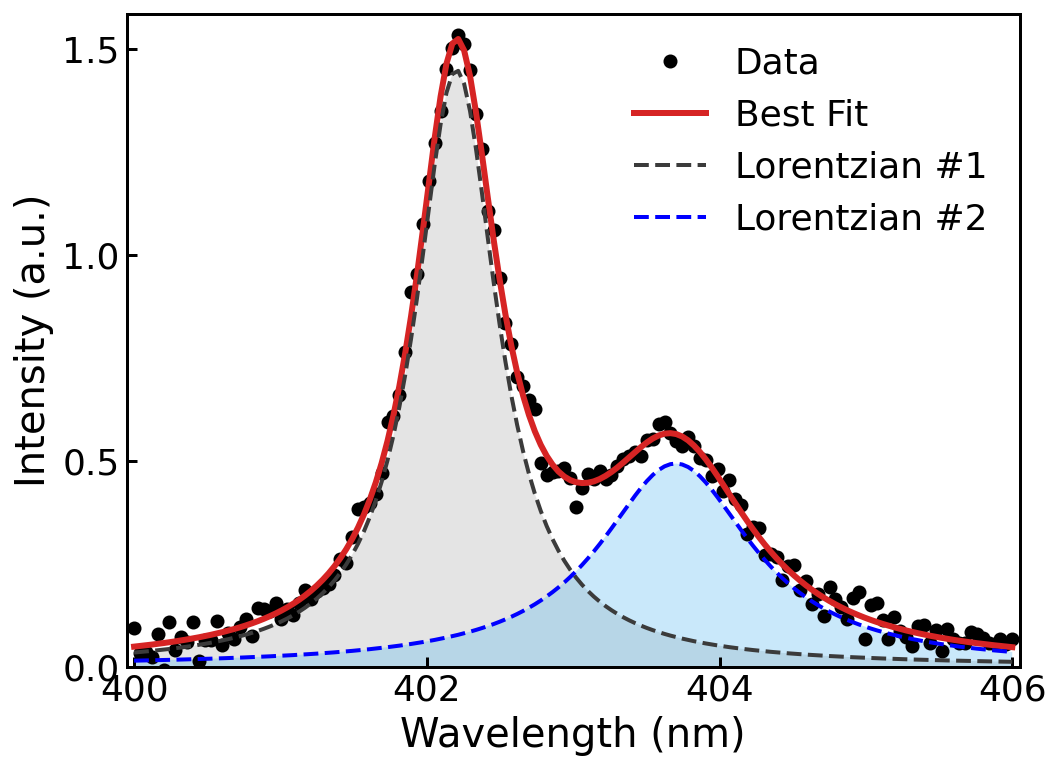

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

# Spectrum + fitted line
ax.plot(x, y, 'ko', label='Data')
ax.plot(x, result.best_fit, color='#D62424', label='Best Fit')

# Lorentzian peak #1
ax.plot(x, L1, color='#3B3B3B', linestyle='--', lw=2, label='Lorentzian #1')
ax.fill_between(x, 0, L1, facecolor='#A8A8A8', alpha=0.3)

# Lorentzian peak #2
ax.plot(x, L2, 'b--', lw=2, label='Lorentzian #2')
ax.fill_between(x, 0, L2, facecolor='#4FB6F1', alpha=0.3)

# Figure customisation
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim([399.95, 406.05])
ax.set_xticks([400, 402, 404, 406])

ax.set_ylabel('Intensity (a.u.)')
ax.set_ylim([0, y.max() + 0.05])
ax.set_yticks([0, 0.50, 1.00, 1.50])

ax.legend(loc=0);

The goodness of fit is impressive!

<br>

### Residual Plot

Additionally, plotting residuals is another reliable way of assessing our model. Simply put, a residual is the difference between the observed value and the predicted value of the dependent variable. As the name suggests, a residual plot is a scatter plot of residuals on the vertical axis and the independent variable on the horizontal axis.

If the points in a residual plot are randomly scattered around zero, our model is appropriate for the data. On the other hand, if there is a pattern in the residual plot, our model does not provide an adequate fit for the data. 

Visualising a residual plot in Python is straightforward:

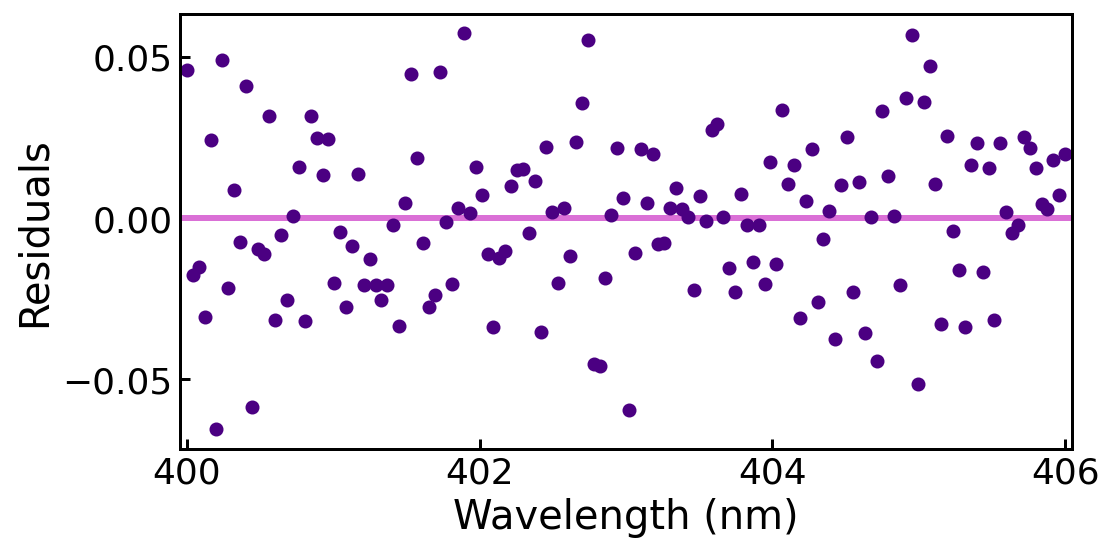

In [10]:
residuals = y - result.best_fit

fig, ax = plt.subplots(figsize=(8, 4))

ax.axhline(y=0, color='orchid', linestyle='-')
ax.plot(x, residuals, color='indigo', marker='o', linestyle='', label='Data')

ax.set_xlabel('Wavelength (nm)')
ax.set_xlim([399.95, 406.05])
ax.set_xticks([400, 402, 404, 406])

ax.set_ylabel('Residuals')
ax.set_yticks([-0.05, 0, 0.05]);

Residuals are randomly dispersed around zero (horizontal line), confirming that our model fits the data well.

<br>

### Final Plot

We can merge the last two plots into one by using `matplotlib`'s `gridspec` (all credits go to [Emily G. Ripka](http://www.emilygraceripka.com/blog/16)):

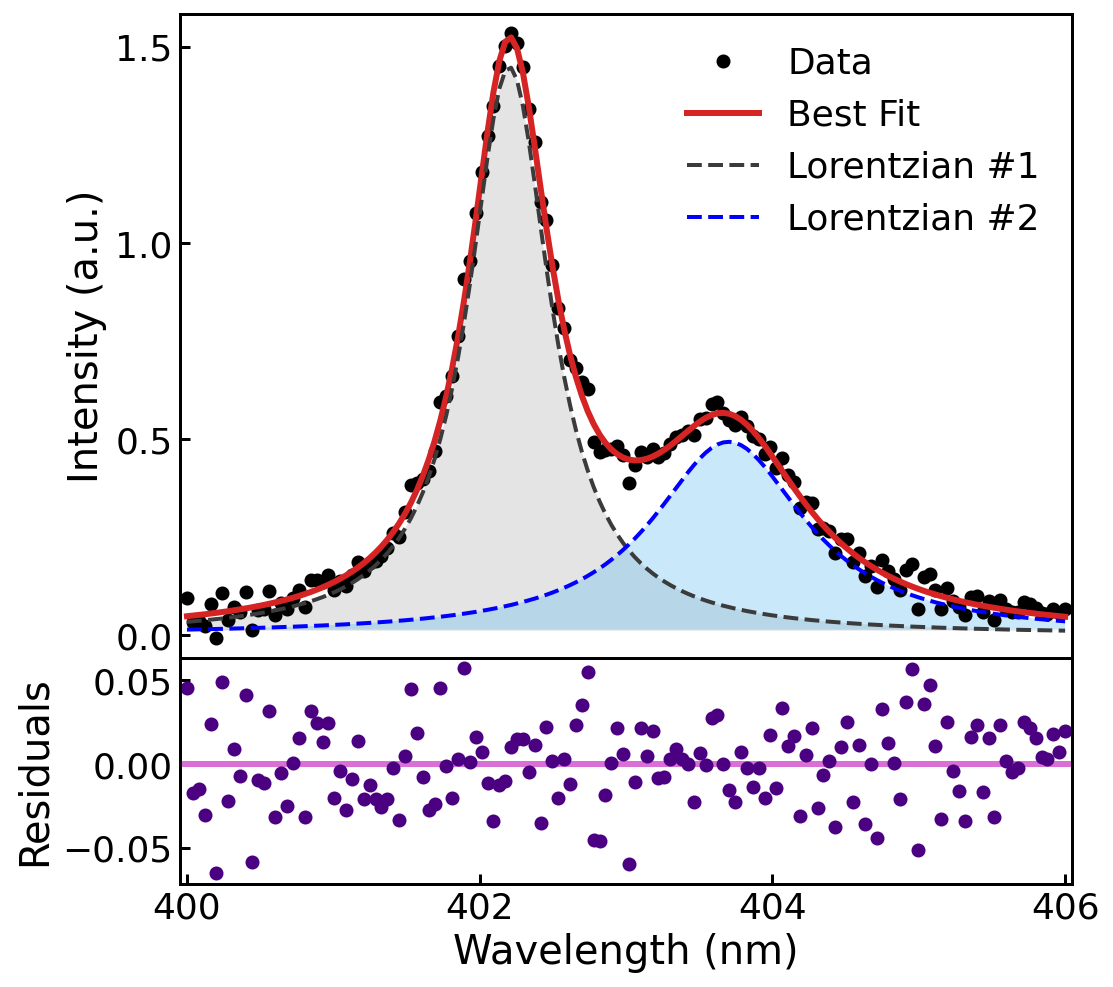

In [11]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.35])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0)

# Plotting data + fits
ax1.plot(x, y, 'ko', label='Data')
ax1.plot(x, result.best_fit, color='#D62424', label='Best Fit')

ax1.plot(x, L1, color='#3B3B3B', linestyle='--', lw=2, label='Lorentzian #1')
ax1.fill_between(x, L1.min(), L1, facecolor='#A8A8A8', alpha=0.3)

ax1.plot(x, L2, 'b--', lw=2, label='Lorentzian #2')
ax1.fill_between(x, L2.min(), L2, facecolor='#4FB6F1', alpha=0.3)

ax1.set_xlim([399.95, 406.05])
ax1.set_xticks([])

ax1.set_ylabel('Intensity (a.u.)')
ax1.set_ylim([y.min() - 0.05, y.max() + 0.05])
ax1.set_yticks([0, 0.50, 1.00, 1.50])

ax1.legend(loc=0)

# Plotting residuals
ax2.axhline(y=0, color='orchid', linestyle='-')
ax2.plot(x, residuals, color='indigo', marker='o', linestyle='', label='Data')

ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim([399.95, 406.05])

ax2.set_ylabel('Residuals')
ax2.set_xticks([400, 402, 404, 406])

plt.savefig('Fitted_Spectrum.png');

<br>